In [59]:
import mxnet as mx
import numpy as np
from mxnet import gluon, nd, autograd
mx.random.seed(1)
import pandas as pd

from mxnet.gluon import nn
%matplotlib inline
from matplotlib import pyplot as plt

In [60]:
from mxnet.gluon.loss import PoissonNLLLoss

In [61]:
df = pd.read_csv('../train.csv',skiprows=1,header=None)

In [62]:
df_wo_nonnumeric = df.select_dtypes(include=np.number)

In [63]:
df_train_y = df_wo_nonnumeric[1]
np_train_y = df_train_y.values
df_train_x = df_wo_nonnumeric.drop(labels=1,axis =1)
np_train_x = df_train_x.values
X = nd.array(np_train_x)
Y  = nd.array(np_train_y)
X.shape, Y.shape

((50999, 17), (50999,))

In [64]:
num_examples = X.shape[0]
num_features = X.shape[1]
epochs = 10
num_outputs = 1
model_ctx = mx.cpu()
data_ctx = mx.cpu()

In [65]:
print("Number of training examples = ", num_examples)
print("Number of input features = ",num_features)
X_mean = nd.mean(X, axis=0)
X_SD = nd.array(np.std(X.asnumpy(),axis=0))
X_nm =  (X - X_mean) / X_SD

Number of training examples =  50999
Number of input features =  17


In [66]:
batch_size = 256
# Genrate the training set usin ArrayDataSet
training_set = gluon.data.DataLoader(gluon.data.ArrayDataset(X_nm,Y), shuffle=True, batch_size = batch_size )

In [67]:
net = nn.Sequential()
# Add a sequence of layers.
net.add(
    nn.Dense(1,activation='relu'),
    nn.Dense(1)
)
    
net

Sequential(
  (0): Dense(None -> 1, Activation(relu))
  (1): Dense(None -> 1, linear)
)

In [73]:
poisson_loss = PoissonNLLLoss(from_logits=False)

In [74]:
# Calculating forward pass output of the model
def poissonloss_hidden(X):
    yhat1 = net(X);
    yhat = nd.exp(yhat1)
    return yhat

In [75]:
net.collect_params().initialize(mx.init.Normal(sigma=1), ctx=mx.cpu())

/Users/gireeg/Desktop/Internship/mxnetrepo/incubator-mxnet/python/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'dense4_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/gireeg/Desktop/Internship/mxnetrepo/incubator-mxnet/python/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'dense5_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)


In [76]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.06})

In [78]:
# Training loop
epochs = 50
loss_sequence = []
loss_seq = []
niter = 0
epochslist = []
num_batches = num_examples / batch_size
smoothing_constant = 0.5
moving_loss = 0

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(training_set):

        with autograd.record():
            output = poissonloss_hidden(data)
            loss =  poisson_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)
        loss_seq.append(est_loss)
        cumulative_loss += nd.mean(loss).asscalar()
    if e % 5 ==0:    
        print("Epoch %s, loss: %s" % (e, cumulative_loss / num_examples))
    loss_sequence.append(cumulative_loss/num_examples)
    epochslist.append(e)

Epoch 0, loss: 0.015497304815439976
Epoch 5, loss: -0.0035030271727004825
Epoch 10, loss: -0.005131188388029644
Epoch 15, loss: -0.00581314224629204
Epoch 20, loss: -0.0060662215554355865
Epoch 25, loss: -0.006156530074553012
Epoch 30, loss: -0.006185517994237251
Epoch 35, loss: -0.00616035693607956
Epoch 40, loss: -0.006200774910099406
Epoch 45, loss: -0.006202472366794221


Text(0,0.5,'loss')

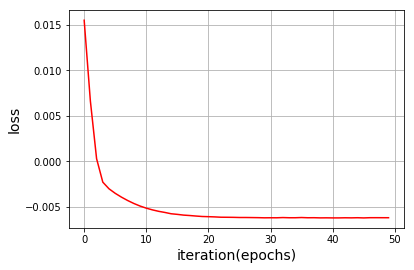

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(epochslist,loss_sequence,color='red')
plt.grid(True,which="both")
plt.xlabel('iteration(epochs)',fontsize=14)
plt.ylabel('loss',fontsize=14)

Text(0,0.5,'est loss')

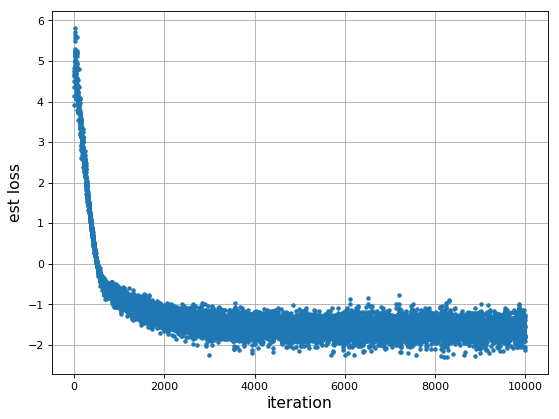

In [80]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6),dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(niter),loss_seq, '.')

# adding some additional bells and whistles to the plot
plt.grid(True,which="both")
plt.xlabel('iteration',fontsize=14)
plt.ylabel('est loss',fontsize=14)